In [ ]:
#@title Подключение к гугл диску
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [49]:
#@title Создание структуры папок
import os

# Корневая директория проекта на Google Drive
BASE_DIR = "/content/drive/MyDrive/VideoRAG"
TMP_DIR = "/content/tmp"

# Определяем пути к папкам
RAW_VIDEO_DIR = os.path.join(BASE_DIR, "raw_videos")
FRAMES_DIR = os.path.join(BASE_DIR, "extracted_frames")
FEATURES_DIR = os.path.join(BASE_DIR, "features")
INDEX_DIR = os.path.join(BASE_DIR, "index")
QUERY_DIR = os.path.join(BASE_DIR, "query_images")
PROCESSED_VIDEO_DIR = os.path.join(BASE_DIR, "processed_videos")

# Список папок для создания
folders = [RAW_VIDEO_DIR, FRAMES_DIR, FEATURES_DIR, INDEX_DIR, QUERY_DIR, PROCESSED_VIDEO_DIR, TMP_DIR]

# Создаем папки, если их нет
for folder in folders:
    os.makedirs(folder, exist_ok=True)

print("Структура папок успешно создана!")

Структура папок успешно создана!


In [50]:
# Проверяем, есть ли видео в нужной папке
video_path = "/content/drive/MyDrive/VideoRAG/raw_videos/example.mp4"
print("Файл существует:", os.path.exists(video_path))

# Если файла нет, вывести список файлов в папке
if not os.path.exists(video_path):
    print("Файлы в папке raw_videos:")
    !ls /content/drive/MyDrive/VideoRAG/raw_videos/

Файл существует: True


In [16]:
#@title Устоновка необходимых библиотек
!pip install torch torchvision
!pip install faiss-cpu  # Для использования FAISS на CPU
!pip install decord     # Для эффективного чтения видео
!pip install clip       # Для модели CLIP
!pip install pandas     # Для работы с CSV и таблицами
!pip install matplotlib # Для визуализации результатов
!pip install tqdm       # Для отображения прогресса
!pip install ftfy regex
!apt install -y ffmpeg

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.


In [57]:
#@title Video RAG System (CLIP + FAISS) - Исправленная версия (с torch.no_grad() в search)
import os
import shutil
import torch
import numpy as np
from PIL import Image
import clip
import decord
import pandas as pd
import faiss
import matplotlib.pyplot as plt
from tqdm import tqdm
import subprocess
import warnings

warnings.filterwarnings('ignore')

device = "cuda" if torch.cuda.is_available() else "cpu"

class Config:
    BASE_DIR = "/content/drive/MyDrive/VideoRAG"
    RAW_VIDEO_DIR = os.path.join(BASE_DIR, "raw_videos")
    PROCESSED_VIDEO_DIR = os.path.join(BASE_DIR, "processed_videos")
    FRAMES_DIR = os.path.join(BASE_DIR, "extracted_frames")
    FEATURES_DIR = os.path.join(BASE_DIR, "features")
    INDEX_DIR = os.path.join(BASE_DIR, "index")
    QUERY_DIR = os.path.join(BASE_DIR, "query_images")
    TMP_DIR = "/content/tmp"

    DEFAULT_FPS = 2
    MAX_WIDTH = 640
    BATCH_SIZE = 64 if torch.cuda.is_available() else 8
    USE_FLOAT16 = True

    @classmethod
    def setup_dirs(cls):
        os.makedirs(cls.RAW_VIDEO_DIR, exist_ok=True)
        os.makedirs(cls.PROCESSED_VIDEO_DIR, exist_ok=True)
        os.makedirs(cls.FRAMES_DIR, exist_ok=True)
        os.makedirs(cls.FEATURES_DIR, exist_ok=True)
        os.makedirs(cls.INDEX_DIR, exist_ok=True)
        os.makedirs(cls.QUERY_DIR, exist_ok=True)
        os.makedirs(cls.TMP_DIR, exist_ok=True)

Config.setup_dirs()

def convert_video(input_path, output_path):
    cmd = [
        'ffmpeg', '-y', '-i', input_path,
        '-c:v', 'libx264', '-preset', 'fast',
        '-vf', f'scale={Config.MAX_WIDTH}:-2',
        '-c:a', 'aac', '-b:a', '128k',
        output_path
    ]
    subprocess.run(cmd, check=True)

def get_video_duration(video_path):
    result = subprocess.run([
        'ffprobe', '-v', 'error',
        '-show_entries', 'format=duration',
        '-of', 'default=noprint_wrappers=1:nokey=1',
        video_path
    ], stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    return float(result.stdout.decode().strip())

def prepare_video(input_path):
    tmp_path = os.path.join(Config.TMP_DIR, os.path.basename(input_path))
    shutil.copy(input_path, tmp_path)
    ext = os.path.splitext(tmp_path)[1].lower()
    if ext not in ['.mp4']:
        output_path = tmp_path.replace(ext, '.mp4')
        convert_video(tmp_path, output_path)
        os.remove(tmp_path)
        tmp_path = output_path
    duration = get_video_duration(tmp_path)
    return tmp_path, duration

def adaptive_fps_selector(duration):
    if duration > 3600:
        return 1
    elif duration > 1800:
        return 2
    else:
        return 3

def extract_frames(video_path, output_dir):
    processed_path, duration = prepare_video(video_path)
    fps = adaptive_fps_selector(duration)
    print(f"Автовыбор параметров: FPS={fps}, длительность={duration//60:.0f} мин")

    vr = decord.VideoReader(processed_path)
    frame_step = max(1, int(vr.get_avg_fps() / fps))
    frame_indices = range(0, len(vr), frame_step)

    video_name = os.path.splitext(os.path.basename(video_path))[0]
    save_dir = os.path.join(output_dir, video_name)
    os.makedirs(save_dir, exist_ok=True)

    timestamps = []
    for idx in tqdm(frame_indices, desc="Извлечение кадров"):
        frame = Image.fromarray(vr[idx].asnumpy())
        timestamp = idx / vr.get_avg_fps()
        frame_name = f"frame_{idx:06d}.jpg"
        frame_path = os.path.join(save_dir, frame_name)
        frame.save(frame_path, quality=85)
        timestamps.append({
            'frame_name': frame_name,
            'timestamp': f"{int(timestamp//3600):02d}:{int((timestamp//60)%60):02d}:{timestamp%60:06.3f}"
        })

    pd.DataFrame(timestamps).to_csv(os.path.join(save_dir, 'timestamps.csv'), index=False)
    return save_dir

def initialize_clip():
    model, preprocess = clip.load("ViT-B/32", device=device)
    if Config.USE_FLOAT16 and device == 'cuda':
        print("Режим float16 активирован (через torch.cuda.amp.autocast)")
    return model, preprocess

def process_frames(frame_dir):
    model, preprocess = initialize_clip()
    frame_files = sorted([f for f in os.listdir(frame_dir) if f.endswith('.jpg')])
    timestamps = pd.read_csv(os.path.join(frame_dir, 'timestamps.csv'))

    class FrameDataset(torch.utils.data.Dataset):
        def __init__(self, frame_dir, files):
            self.frame_dir = frame_dir
            self.files = files
            self.cache = {}
        def __len__(self):
            return len(self.files)
        def __getitem__(self, idx):
            if idx not in self.cache:
                path = os.path.join(self.frame_dir, self.files[idx])
                image = preprocess(Image.open(path))
                self.cache[idx] = image
            return self.cache[idx]

    dataset = FrameDataset(frame_dir, frame_files)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=Config.BATCH_SIZE, num_workers=2)

    features = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Векторизация"):
            batch = batch.to(device)
            if Config.USE_FLOAT16 and device == "cuda":
                with torch.cuda.amp.autocast():
                    output = model.encode_image(batch)
            else:
                output = model.encode_image(batch)
            features.append(output.cpu().to(dtype=torch.float32))

    features = torch.cat(features)
    video_name = os.path.basename(frame_dir)
    feature_path = os.path.join(Config.FEATURES_DIR, f'{video_name}_features.pt')
    torch.save(features, feature_path)
    timestamp_path = os.path.join(Config.FEATURES_DIR, f'{video_name}_timestamps.pt')
    torch.save(timestamps, timestamp_path)
    return feature_path

def build_index(feature_path):
    features = torch.load(feature_path).numpy().astype(np.float32)
    faiss.normalize_L2(features)
    index = faiss.IndexFlatIP(features.shape[1])
    index.add(features)
    index_path = os.path.join(Config.INDEX_DIR, os.path.basename(feature_path).replace('_features.pt', '.faiss'))
    faiss.write_index(index, index_path)
    return index_path

def search(query_path, index_path, timestamp_path, k=5):
    try:
        model, preprocess = initialize_clip()
        image = preprocess(Image.open(query_path)).unsqueeze(0).to(device)
        with torch.no_grad():
            if Config.USE_FLOAT16 and device == "cuda":
                with torch.cuda.amp.autocast():
                    query_image = model.encode_image(image)
            else:
                query_image = model.encode_image(image)
        # Используем detach() перед вызовом numpy()
        query = query_image.detach().cpu().numpy().astype(np.float32)
        index = faiss.read_index(index_path)
        faiss.normalize_L2(query)
        distances, indices = index.search(query, k)
        timestamps = torch.load(timestamp_path)
        results = timestamps.iloc[indices[0]].copy()
        results['score'] = distances[0]
        return results
    except Exception as e:
        print(f"Ошибка поиска: {str(e)}")
        return pd.DataFrame()

def visualize_results(results, frame_dir):
    plt.figure(figsize=(20, 10))
    for i, (idx, row) in enumerate(results.iterrows()):
        path = os.path.join(frame_dir, row['frame_name'])
        img = Image.open(path)
        plt.subplot(1, len(results), i+1)
        plt.imshow(img)
        plt.title(f"Time: {row['timestamp']}\nScore: {row['score']:.3f}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def generate_report(results, video_path):
    report = [
        "Отчет по поиску:",
        f"Видео: {os.path.basename(video_path)}",
        f"Найдено результатов: {len(results)}",
        "\nТоп-5 совпадений:"
    ]
    for i, (_, row) in enumerate(results.iterrows()):
        report.append(f"{i+1}. Время: {row['timestamp']} | Сходство: {row['score']:.3f}")
    return "\n".join(report)

def main(video_filename, query_filename):
    try:
        video_path = os.path.join(Config.RAW_VIDEO_DIR, video_filename)
        query_path = os.path.join(Config.QUERY_DIR, query_filename)
        frame_dir = extract_frames(video_path, Config.FRAMES_DIR)
        feature_path = process_frames(frame_dir)
        index_path = build_index(feature_path)
        timestamp_path = feature_path.replace('_features.pt', '_timestamps.pt')
        results = search(query_path, index_path, timestamp_path)
        if not results.empty:
            visualize_results(results, frame_dir)
            print(generate_report(results, video_path))
        else:
            print("Совпадений не найдено")
        return results
    except RuntimeError as e:
        if 'CUDA out of memory' in str(e):
            print("\nОШИБКА ПАМЯТИ! Рекомендации:")
            print("1. Уменьшите BATCH_SIZE в Config")
            print("2. Используйте Config.USE_FLOAT16 = True")
            print("3. Уменьшите FPS через adaptive_fps_selector()")
        else:
            print(f"Критическая ошибка: {str(e)}")
    except Exception as e:
        print(f"Ошибка выполнения: {str(e)}")


In [58]:
#@title Вырезание сегментов видео
import subprocess

def timestamp_to_seconds(timestamp_str):
    """Преобразует время из 'HH:MM:SS.mmm' в секунды (float)."""
    h, m, s = timestamp_str.split(':')
    return int(h)*3600 + int(m)*60 + float(s)

def seconds_to_timestamp(seconds):
    """Преобразует время в секундах в строку 'HH:MM:SS.mmm'."""
    hours = int(seconds // 3600)
    seconds -= hours * 3600
    minutes = int(seconds // 60)
    seconds -= minutes * 60
    return f"{hours:02d}:{minutes:02d}:{seconds:06.3f}"

def extract_video_segment(video_path, timestamp_str, clip_duration, output_dir, clip_index):
    """
    Вырезает сегмент видео заданной длительности, центрированный вокруг указанной временной метки.

    :param video_path: Путь к исходному видео.
    :param timestamp_str: Метка времени в формате 'HH:MM:SS.mmm'.
    :param clip_duration: Длительность клипа (в секундах).
    :param output_dir: Папка для сохранения клипа.
    :param clip_index: Индекс клипа (для формирования имени файла).
    """
    timestamp_sec = timestamp_to_seconds(timestamp_str)
    # Начало клипа: вычитаем половину длительности (не менее нуля)
    start_sec = max(0, timestamp_sec - clip_duration / 2)
    start_time_str = seconds_to_timestamp(start_sec)

    output_filename = os.path.join(output_dir, f"clip_{clip_index:02d}.mp4")

    cmd = [
        "ffmpeg",
        "-y",
        "-ss", start_time_str,
        "-i", video_path,
        "-t", str(clip_duration),
        "-c", "copy",  # быстрое копирование без перекодирования
        output_filename
    ]
    try:
        subprocess.run(cmd, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        print(f"Извлечён клип: {output_filename} (начало: {start_time_str}, длительность: {clip_duration} сек.)")
    except subprocess.CalledProcessError as e:
        print(f"Ошибка при извлечении клипа: {e.stderr.decode()}")

def cut_segments_from_results(video_path, results, clip_duration=10):
    """
    Для каждого результата поиска вырезает клип из видео.

    :param video_path: Путь к исходному видео.
    :param results: DataFrame с результатами поиска (с колонкой 'timestamp').
    :param clip_duration: Длительность каждого клипа в секундах.
    """
    output_dir = Config.PROCESSED_VIDEO_DIR
    os.makedirs(output_dir, exist_ok=True)
    for idx, row in results.iterrows():
        timestamp_str = row['timestamp']
        extract_video_segment(video_path, timestamp_str, clip_duration, output_dir, idx+1)


Автовыбор параметров: FPS=2, длительность=43 мин


Извлечение кадров: 100%|██████████| 5647/5647 [07:55<00:00, 11.87it/s]


Режим float16 активирован (через torch.cuda.amp.autocast)


Векторизация: 100%|██████████| 177/177 [02:49<00:00,  1.04it/s]


Режим float16 активирован (через torch.cuda.amp.autocast)


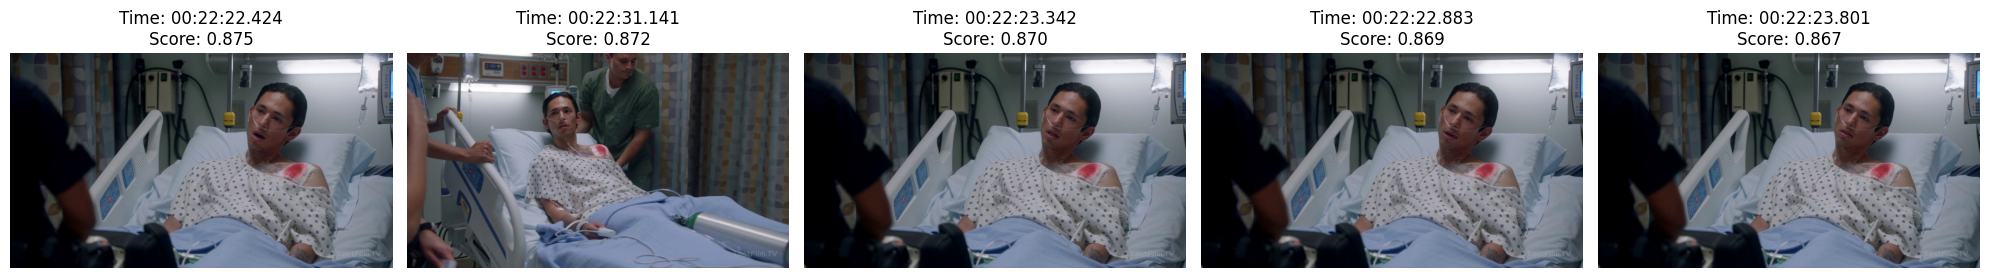

Отчет по поиску:
Видео: example.mp4
Найдено результатов: 5

Топ-5 совпадений:
1. Время: 00:22:22.424 | Сходство: 0.875
2. Время: 00:22:31.141 | Сходство: 0.872
3. Время: 00:22:23.342 | Сходство: 0.870
4. Время: 00:22:22.883 | Сходство: 0.869
5. Время: 00:22:23.801 | Сходство: 0.867
Извлечён клип: /content/drive/MyDrive/VideoRAG/processed_videos/clip_2927.mp4 (начало: 00:22:17.424, длительность: 10 сек.)
Извлечён клип: /content/drive/MyDrive/VideoRAG/processed_videos/clip_2946.mp4 (начало: 00:22:26.141, длительность: 10 сек.)
Извлечён клип: /content/drive/MyDrive/VideoRAG/processed_videos/clip_2929.mp4 (начало: 00:22:18.342, длительность: 10 сек.)
Извлечён клип: /content/drive/MyDrive/VideoRAG/processed_videos/clip_2928.mp4 (начало: 00:22:17.883, длительность: 10 сек.)
Извлечён клип: /content/drive/MyDrive/VideoRAG/processed_videos/clip_2930.mp4 (начало: 00:22:18.801, длительность: 10 сек.)


In [59]:
#@title Пример использования
# Настройка параметров
Config.BATCH_SIZE = 32
Config.USE_FLOAT16 = True

# Запускаем основной пайплайн (извлечение кадров, векторизация, индексирование, поиск)
results = main("example.mp4", "query.jpg")

# Если результаты найдены, вырезаем сегменты видео (например, клипы по 10 секунд)
if results is not None and not results.empty:
    video_path = os.path.join(Config.RAW_VIDEO_DIR, "example.mp4")
    cut_segments_from_results(video_path, results, clip_duration=10)
